
# Get normal face sizes to discard customers that are too far or too close

### imports and configs

In [1]:
import mtcnn
import cv2
import os,sys
import glob
import skimage
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm

%matplotlib inline

In [2]:
project_dir = os.path.realpath('..')
if not project_dir in sys.path: sys.path.insert(0, project_dir)

In [4]:
os.environ['DB_PASSWORD'] = 'asdf'

In [5]:
utils = importlib.import_module('src.utils', project_dir)
clustering = importlib.import_module('src.cluster_faces', project_dir)

In [8]:
out = '../data/raw/juul_shots_new/'
video = '/mnt/neurus_storage04/RG_mnt/juul_2019-08-07/1565173458.mp4'

### retrieve frames for visual

In [9]:
SKIP = 113
STOP_AT = 6111

In [10]:
!rm -rf $out

In [11]:
os.makedirs(out, exist_ok=False)

In [12]:
cap = cv2.VideoCapture(video)

i = 0
while cap.isOpened():
    ret = cap.grab()
    if i % SKIP == 0:
        ret,frame = cap.retrieve()
        if ret:
            filename = os.path.basename(video).split('.')[0]
            filename = '_'.join([filename, str(i)]) + '.jpg'
            filepath = os.path.join(out, filename)
            cv2.imwrite(filepath, frame)
    if i > STOP_AT: break
    i += 1

### Detect faces on images

In [13]:
pnet,rnet,onet = mtcnn.get_net_caffe('../src/FaceDetector/output/caffe_models/')
detector = mtcnn.FaceDetector(pnet, rnet, onet, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/mtcnn/network/mtcnn_pytorch.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/usr/local/lib/python3.7/dist-packages/mtcnn/network/mtcnn_pytorch.py:10: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)


In [14]:
img_paths = glob.glob(out + '*.jpg')
len(img_paths)

55

In [15]:
def show_detection_sizes(image_paths):
    for path in image_paths:
        img = cv2.imread(path)
        boxes,_ = detector.detect(img, threshold=[0.6,0.7,0.9], minsize=100)
        print(path, 'Faces:', len(boxes))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if len(boxes) > 0:
            boxes = boxes.cpu().numpy()
            sizes = clustering.calc_sizes(boxes)
            text_sizes = [f'({w:.0f}, {h:.0f})' for w,h in sizes]
            utils.draw_rectangles(img, boxes, texts=text_sizes, fontScale=1.5, thickness=3, 
                                  color=(255,0,0))
        plt.figure(figsize=(14,7))
        skimage.io.imshow(img,)
        yield plt.show()

In [16]:
image_generator = show_detection_sizes(img_paths)

../data/raw/juul_shots_new/1565173458_5763.jpg Faces: 1


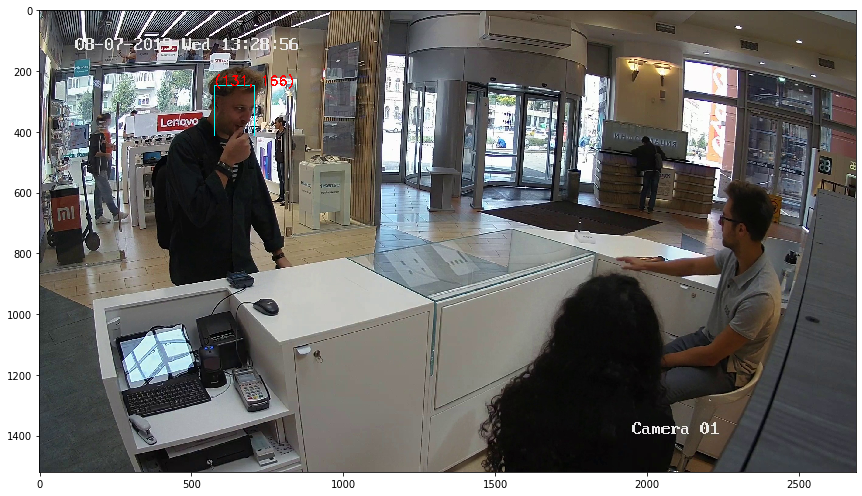

In [24]:
next(image_generator)

### Conclusions

После ручного просмотра изображений можно выставить:
- detector.detect(..., minsize=100)
- min width = 60
- min heigh = 80